# Rothamsted Spinup
This notebook runs the whole spinup for the Rothamsted site, including:
1. Pre-BG spinup
2. BG spinup
3. Full spinup

## 1. Pre-BG Spinup

As a first step we run the spinup without the biogeochemistry module activated. For this we will use a truncated version of the prova-file, which does not specify the paths of the parameter and output files. We will do so ourselves and then call the main routine `MAIN_FRAME` directly from this notebook.

In [161]:
cd 'TnC Explained'

Error using cd
Unable to change current folder to 'C:\Users\fcbauer\OneDrive - epfl.ch\Desktop\Software\TnC Explained\TnC Explained' (Name is nonexistent or not a folder).

In [170]:
pwd

ans = 'C:\Users\fcbauer\OneDrive - epfl.ch\Desktop\Software\TnC Explained'

In [17]:
clear all;
% Add T&C Code directory to path so we don't need to navigate between folders from *within* the scripts
addpath("T&C_CODE");

% Descriptor will be saved with all other variables and can be helpful to reconstruct what has been done
descriptor = "Set NPK reserves at planting such that there should be just no nutrient constrains, but not much higher";
short_descriptor = 'npk_res_ini_35_05_15';
% Run truncated prova file to perform standard initialization
cd("PARAMETER_PLOT_FILES");
prova_Rothamsted_Spinup;

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Use parameters for initial spinup
param_filename = ['MOD_PARAM_' id_location '_Spinup_common'];

PARAM_IC = [current_directory filesep param_filename];
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
cd("..");
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
MAIN_FRAME ;
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% cd(current_directory);
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
timestamp = datestr(now, "yy-mm-dd-HHMM");
initial_spinup_results_folder = ['results' filesep 'initial_spinup'];
mkdir(initial_spinup_results_folder);
initial_spinup_result_fn = [timestamp '_' id_location '_' short_descriptor '.mat'];
initial_spinup_results_path = [initial_spinup_results_folder filesep initial_spinup_result_fn];
save(initial_spinup_results_path);

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.

Iter:
     2

Iter:
        1000

Iter:
        2000

Iter:
        3000

Iter:
        4000

Iter:
        5000

Iter:
        6000

Iter:
        7000

Iter:
        8000

Iter:
        9000

Iter:
       10000

Iter:
       11000

Iter:
       12000

Iter:
       13000

Iter:
       14000

Iter:
       15000

Iter:
       16000

Iter:
       17000

Iter:
       18000

Iter:
       19000

Iter:
       20000

Iter:
       21000

Iter:
       22000

Iter:
       23000

Iter:
       24000

Iter:
       25000

Iter:
       26000

Iter:
       27000

Iter:
       28000

Iter:
       29000

Iter:
       30000

Iter:
       31000

Iter:
       32000

Iter:
       33000

Iter:
       34000

Iter:
       35000

Iter:
       36000

Iter:
       37000

Iter:
       38000

Iter:
       39000

Iter:
       40000

Iter:
       41000

Iter:
       42000

Iter:
       43000

Iter:
       44000

Iter:
       45000

Iter:
       46000

Iter:
       47000

Iter:
       48000

Iter:
       49000

Iter:


### 1.1 Calibration

Here, we can compare some of the model outputs, such as yield with recorded field values to get an idea if it matches. If not, the spinup should be repeated with modified parameters.
We will start by calculating the total simulated straw and grain yields per year.

In [10]:
years_daily = Datam(1:24:end,1); %! Year for each day of the simulation (Datam is in h, hence only every 24th)
years = unique(years_daily);
years = years(2:end); % Ignore first year, which has no harvest
yield_yearly_pred = zeros(length(years), cc, 7);
for i=1:length(years)
    yr = years(i);
    yield_yearly_pred(i, :, :) = sum(RB_L(years_daily==yr, :, :));
end
grain_yearly_pred = sum(yield_yearly_pred(:, :, [4, 5]), 3); %! Grains are fruit (5) and C reserve (4) compartments
straw_yearly_pred = sum(yield_yearly_pred(:, :, [1, 2, 7]), 3); %! Straw is leaves (1), sapwood (2), and dead leaves (7) compartments

In [5]:
relevant_strip = 21;  %! Strip 3: No fertilizer, 21 (=2.1): Most fertilizer, highest yield
crop_data = readtable(['data' filesep 'Rothamsted_yield_data.csv']);
crop_data = crop_data((crop_data.section == relevant_section) & (crop_data.strip == relevant_strip), :);

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.

To compare with the reported yields from the field, we need to make sure that the units match (gC/m^2 vs. t/ha, where t is tons of 85% dry matter, and C content of dry matter is about 45% for grain and straw).

In [11]:
grain_yearly_obs = zeros(length(years), 1);
straw_yearly_obs = zeros(length(years), 1);
obs_dry_matter = 0.8;
c_content_grain = 0.45;
c_content_straw = 0.45;
grain_conversion_factor = obs_dry_matter * c_content_grain * 1e2;  %! from t/ha to gC/m^2
straw_conversion_factor = obs_dry_matter * c_content_straw * 1e2;  %! from t/ha to gC/m^2
for i=1:length(years)
    yr = years(i);
    grain_yearly_obs(i) = crop_data.grain(crop_data.harvest_year==yr) * grain_conversion_factor;
    straw_yearly_obs(i) = crop_data.straw(crop_data.harvest_year==yr) * straw_conversion_factor;
end

In [16]:
disp(['Mean grain yields - observed: ' num2str(mean(grain_yearly_obs)) ' , predicted: ' num2str(mean(grain_yearly_pred))])

Mean grain yields - observed: 282.84 , predicted: 256.2699


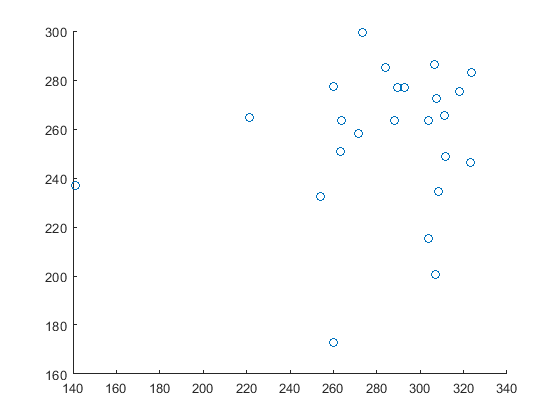

In [13]:
figure
scatter(grain_yearly_obs, grain_yearly_pred)

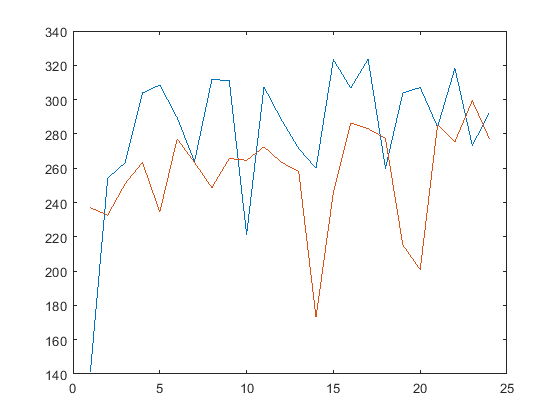

In [14]:
figure
plot(grain_yearly_obs)
hold on
plot(grain_yearly_pred)

## 2. BG Spinup

Now we will run the biogeochemistry spinup in isolation from the rest, for bouts of 100 years at once, and repeat that until the values for the BG pools remain relatively constant.

First we will add a folder to the matlab path that has a few functions defined that we will use here. We will also add the 'T&C_CODE' folder, to make sure it is still on the path.

In [1]:
addpath("biogeochemistry_spinup_functions");
addpath("T&C_CODE");

### 2.1. Load results from spinup

In [2]:
load(initial_spinup_results_path);

#### 2.1.a If simulations include woody vegetation
If your vegetation includes wook, you will have to derive the wood turnover coefficient (`Wm_H` and/or `Wm_L`) after the first spinup. You should then run a second spinup with the parameter file containing the correct values for this coefficient. See Simone Fatichi's tutorial video for details.

### 2.2. Run biogeochemistry spinup

The biogeochemistry spinup will run in multiple epochs. At each epoch the spinup continues from the previous state for a given number of years (`Nyears_epoch`). The spinup ends, if at the end of an epoch the value of none of the biogeochemistry pools has changed more than a given percentage (`rtol`), or if the maximum number of epochs (`N_epochs_max`) is reached.

Below, we define the parameters mentioned above, as well as the path to the file holding deposition data.

In [190]:
pwd

ans = 'C:\Users\fcbauer\OneDrive - epfl.ch\Desktop\Software\TnC Explained'

In [4]:
Nyears_epoch = 100;
N_epochs_max = 100;
rtol = 0.05; %! If none of the pools changes more than 5% during an epoch, the spinup ends
path_deposition_data = ['data' 'Inputs' 'All_deposition_data.mat'];
bg_save_folder = ['results' filesep 'bg_spinup'];
mkdir(bg_save_folder);
bg_save_path = [bg_save_folder filesep  timestamp];

% Preprocessing - Function arguments are from initial spinup
[Se, Se_fc, Psi_s, Ts, V, VT] = bg_preprocess(Ta, Tdp, O, V, Soil_Param, Phy, SPAR, Bio_Zs);

License checkout failed.
License Manager Error 4410
Invalid security token. (Status code: Unauthorized)

Troubleshoot this issue by visiting: 
https://www.mathworks.com/support/lme/4410

Diagnostic Information:
Feature: Statistics_Toolbox 
License path:  
Licensing error: 4410,0.

Error in bg_preprocess (line 12)
    Se = (log(nanmean(Aew)/0.000008575)/11.67)*Se_fc;

Spin-up epoch :  of 55 elements in steady state.
Spin-up epoch :  of 55 elements in steady state.
Spin-up epoch :   of 55 elements in steady state.
Spin-up epoch : & of 55 elements in steady state.
Spin-up epoch : ) of 55 elements in steady state.
Spin-up epoch : 0 of 55 elements in steady state.
Spin-up epoch : 1 of 55 elements in steady state.
Spin-up epoch: 6 of 55 elements in steady state.
Spin-up epoch 	: 6 of 55 elements in steady state.
Spin-up epoch 
: 6 of 55 elements in steady state.
Spin-up complete


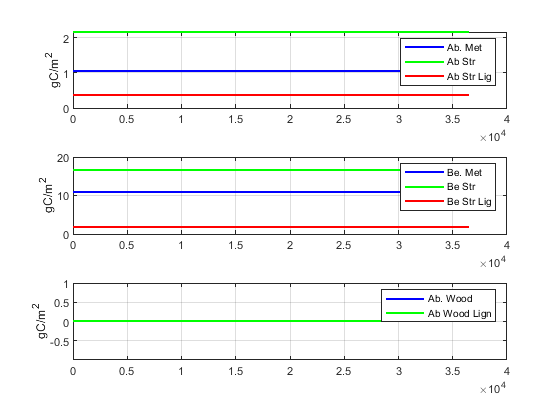

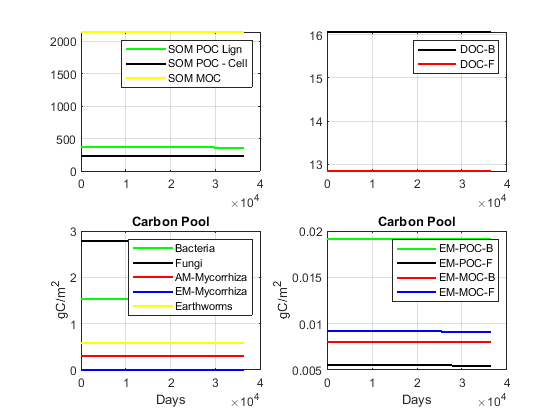

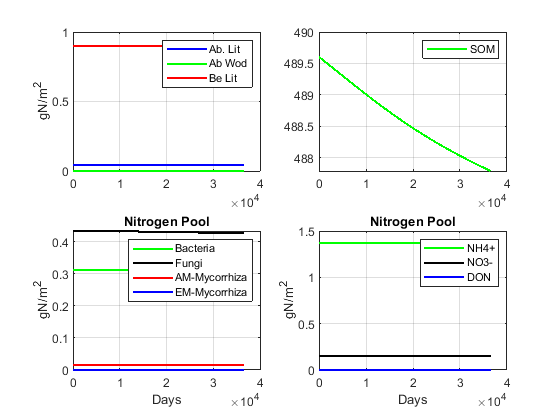

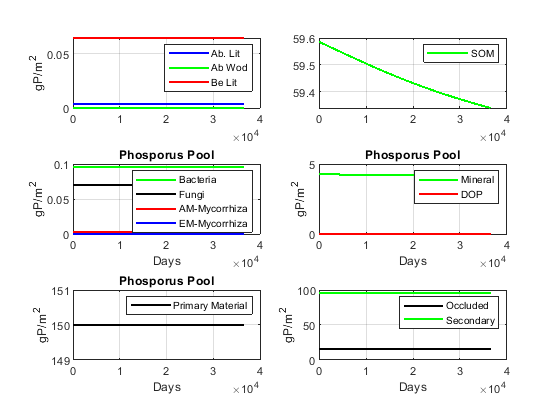

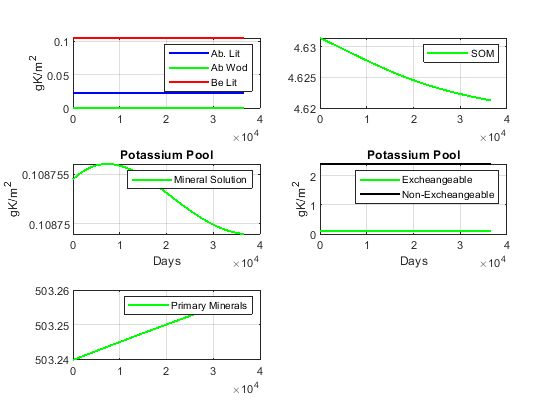

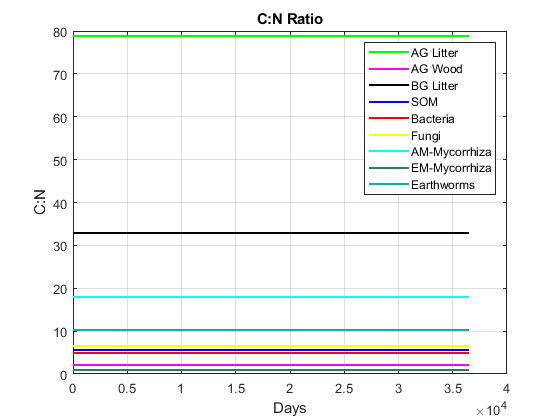

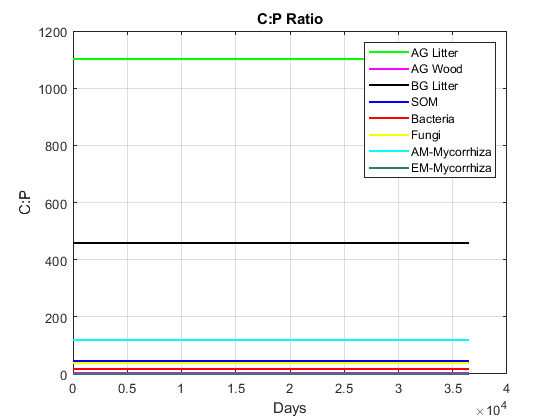

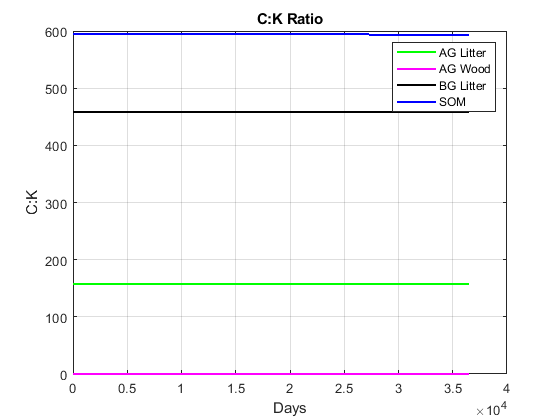

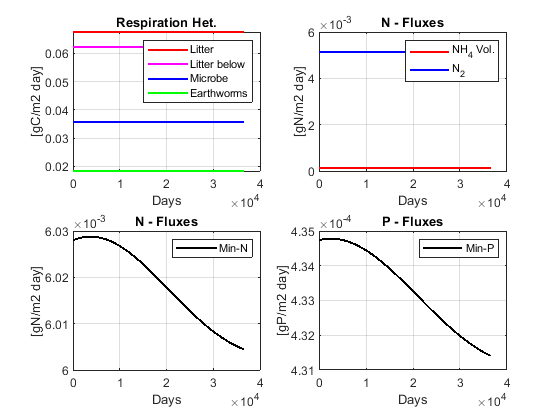

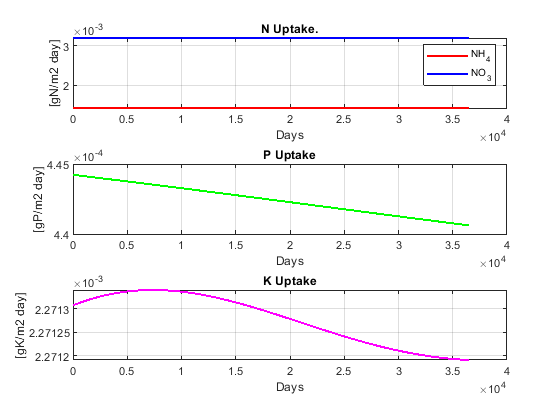

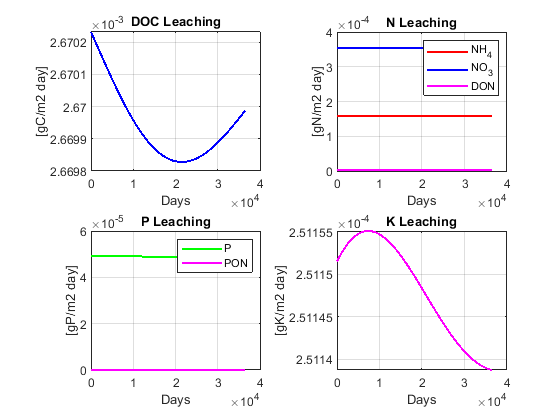

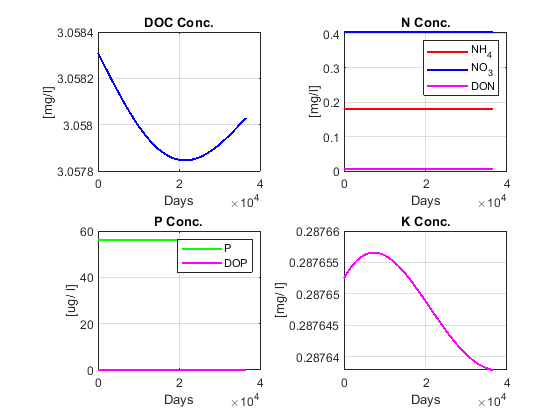

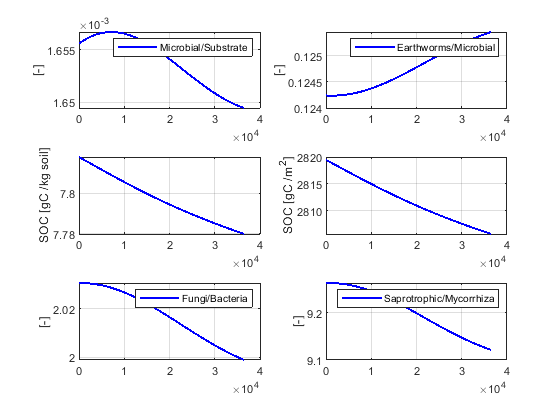

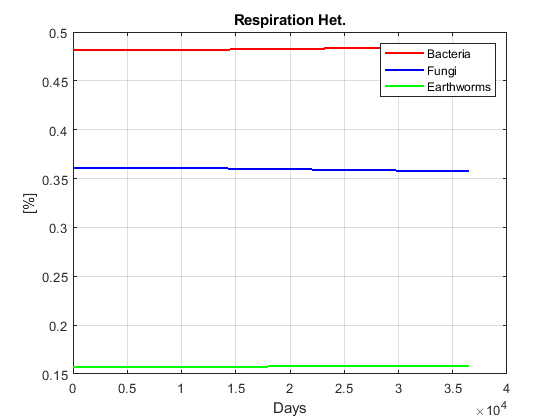

In [79]:
% The actual spinup
[B, R_litter, R_litter_sur, R_microbe, R_bacteria, R_ew, VOL, BfixN, Min_N, Min_P, RmycAM, RmycEM, ...
    N2flx, NH4_Uptake, NO3_Uptake, P_Uptake, K_Uptake, LEAK_NH4, LEAK_NO3, LEAK_P, LEAK_K, LEAK_DOC, ...
    LEAK_DON, LEAK_DOP, Lk] = bg_spinup(Lat, Lon, N_epochs_max, Nyears_epoch, ISOIL_H+ISOIL_L, Zbio, rsd, ...
    Pcla, Psan, PHs, Zs, Ts, Ta, Psi_s, Se, Se_fc, V, VT, T_L, T_H, Lk, RexmyI, Ccrown, B_H+B_L, rtol, bg_save_path);

% Plot results of final epoch (states should not change significantly anymore)
bg_plot(B, R_litter, R_litter_sur, R_microbe, R_bacteria, R_ew, VOL, BfixN, Min_N, Min_P, RmycAM, RmycEM, ...
    N2flx, NH4_Uptake, NO3_Uptake, P_Uptake, K_Uptake, LEAK_NH4, LEAK_NO3, LEAK_P, LEAK_K, LEAK_DOC, ...
    LEAK_DON, LEAK_DOP, Lk, Zbio, rsd);

### 2.3. Export relevant variables
Finally, we save the final state of the biogeochemistry nutrient pools.

In [ ]:
B_end = B(end, :);
bg_save_path_final = [bg_save_path '_final.mat'];
save(bg_save_path_final, "B_end");

## 3 Full spin-up

In [ ]:
clear -except initial_spinup_results_path, bg_save_path_final
prev_data = load(initial_spinup_results_path);
prev_bg = load(bg_save_path_final).B_end;